### 加载训练数据

In [3]:
import numpy as np
train_dict = np.load('data_dic.npy', allow_pickle=True).item()
print(train_dict.keys())

dict_keys(['train_losses', 'train_IoU', 'val_losses', 'val_IoU'])


### 训练数据可视化

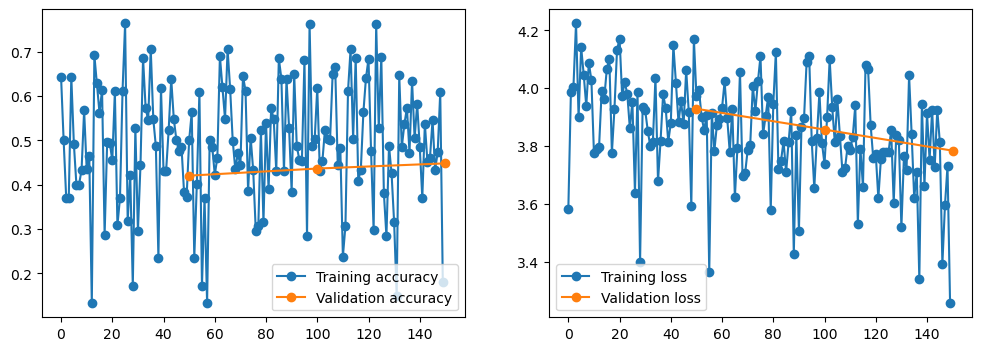

In [9]:
def plot_data(train_accs, val_accs, train_losses, val_losses, step_size):
    import matplotlib.pyplot as plt
    train_idx = np.arange(0, len(train_accs))
    val_idx = np.arange(0, len(train_accs), step_size) + step_size
    train_accs_step = train_accs
    val_accs_step = val_accs
    # x = [str(i) for i in range(len(train_accs_step))]

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))

    ax1.plot(train_idx, train_accs_step,'-o',label='Training mIoU')
    ax1.plot(val_idx, val_accs_step,'-o',label='Validation mIoU')
    ax1.legend(loc='best')

    train_losses_step = train_losses
    val_losses_step = val_losses
    x = [str(i) for i in range(len(train_losses_step))]
    ax2.plot(train_idx, train_losses_step,'-o',label='Training loss')
    ax2.plot(val_idx, val_losses_step,'-o',label='Validation loss')
    ax2.legend(loc='best')
    plt.show()

train_losses = train_dict['train_losses']
train_IoU = train_dict['train_IoU']
val_losses = train_dict['val_losses']
val_IoU = train_dict['val_IoU']

plot_data(train_IoU, val_IoU, train_losses, val_losses, 50)

### 与原始数据在测试集进行性能比较

In [10]:
from dataset_tools import ADE20KDataset
from dataset_tools import TensorDataset

device = 'cuda:0'

test_tensor_path = '/root/Desktop/我的网盘/inference_tensor_test/'
test_img_path = '/root/Desktop/我的网盘/test_set/img_test/'
test_label_path = '/root/Desktop/我的网盘/test_set/label/'

test_tensor_dataset = TensorDataset(test_tensor_path, test_label_path, device)
test_img_dataset = ADE20KDataset(test_img_path, test_label_path)

In [13]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

pspnet_config_file = '../configs/pspnet/pspnet_r50-d8_512x512_80k_ade20k.py'
pspnet_checkpoint_file = '../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth'

deeplabv3plus_config_file = '../configs/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k.py'
deeplabv3plus_checkpoint_file = '../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth'

fcn_config_file = '../configs/fcn/fcn_r50-d8_512x512_80k_ade20k.py'
fcn_checkpoint_file = '../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth'

# build the model from a config file and a checkpoint file
# model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

pspnet_model = init_segmentor(pspnet_config_file, pspnet_checkpoint_file, device='cuda:0')

deeplabv3plus_model = init_segmentor(deeplabv3plus_config_file, deeplabv3plus_checkpoint_file, device='cuda:0')

fcn_model = init_segmentor(fcn_config_file, fcn_checkpoint_file, device='cuda:0')

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

### 基础模型结果推理

In [ ]:
import numpy as np
from mmseg.core.evaluation import metrics
from tools import majorVote
import torch

def get_model_IoU(idx, model):
    img_path = test_img_dataset.get_img_path(idx)
    label = ADE20KDataset.get_label_as_PIL(idx) - 1

    pspnet_result = inference_segmentor(pspnet_model, img_path)
    fcn_result = inference_segmentor(fcn_model, img_path)
    deeplabv3p_result = inference_segmentor(deeplabv3plus_model, img_path)
    # show_result_pyplot(pspnet_model, img_path, result, get_palette('ade20k'))

    pspnet_result = np.array(pspnet_result[0], dtype = np.uint8)
    fcn_result = np.array(fcn_result[0], dtype = np.uint8)
    deeplabv3p_result = np.array(deeplabv3p_result[0], dtype = np.uint8)

    # Major vote
    fuse_res = majorVote(pspnet_result, fcn_result, deeplabv3p_result)

    # FusionModel inference
    tensor_dict, annotation_tensor = test_tensor_dataset[idx]
    annotation_tensor = annotation_tensor - 1 # 忽略背景类，将label范围从1-150变为0-149

    deeplabv3p_logits_res = tensor_dict['deeplabv3p'].to(device)
    pspnet_logits_res = tensor_dict['pspnet'].to(device)
    fcn_logits_res = tensor_dict['fcn'].to(device)

    res = model.forward(deeplabv3p_logits_res, pspnet_logits_res, fcn_logits_res).unsqueeze(0) # (150, H, W)
    res = torch.argmax(res, dim=0).cpu().numpy()

    # calculate IoU
    
    pspnet_IoU_result = np.nanmean(metrics.mean_iou([label], [pspnet_result], 150, -1)['IoU'])
    fusion_IoU_result = np.nanmean(metrics.mean_iou([label], [res], 150, -1)['IoU'])
    vote_IoU_result = np.nanmean(metrics.mean_iou([label], [fuse_res], 150, -1)['IoU'])
    fcn_IoU_result = np.nanmean(metrics.mean_iou([label], [fcn_result], 150, -1)['IoU'])
    deeplabv3p_IoU_result = np.nanmean(metrics.mean_iou([label], [deeplabv3p_result], 150, -1)['IoU'])

    return pspnet_IoU_result, fusion_IoU_result, vote_IoU_result, fcn_IoU_result, deeplabv3p_IoU_result

model = torch.load('/root/Desktop/我的网盘/fusion_model.pth')
pspnet_IoU_result, fusion_IoU_result, vote_IoU_result, fcn_IoU_result, deeplabv3p_IoU_result = get_model_IoU(0, model)
print("pspnet_IoU_result: ", pspnet_IoU_result)
print("fcn_IoU_result: ", fcn_IoU_result)
print("deeplabv3p_IoU_result: ", deeplabv3p_IoU_result)
print("vote_IoU_result: ", vote_IoU_result)
print("fusion_IoU_result: ", fusion_IoU_result)

### 画出Test set上表现最好的方法

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

test_IoU = []
for i in range(len(test_img_dataset)):
    pspnet_IoU_result, fusion_IoU_result, vote_IoU_result, fcn_IoU_result, deeplabv3p_IoU_result = get_model_IoU(i, model)
    iter_IoU = [pspnet_IoU_result, fusion_IoU_result, vote_IoU_result, fcn_IoU_result, deeplabv3p_IoU_result]
    test_IoU.append(iter_IoU)

best_method = []
method_dic = {0:'pspnet', 1:'fusion', 2:'vote', 3:'fcn', 4:'deeplabv3p'}
for res in test_IoU:
    best_method.append(method_dic[np.argmax(res)])

performance = Counter(best_method)
plt.bar(performance.keys(), performance.values())